# Text Analytics Coursework - MSc in Big Data Analytics

#### July 2023


## --- Answer (a) ---

In [1]:
#Importing the required libraries

import os
import shutil
import re
import urllib.request
import requests
import pandas as pd
import json
import time
import nltk
from tqdm import tqdm
from random import random
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
import nltk.corpus as Corpus
import tensorflow as tf
from sklearn import metrics
from tabulate import tabulate
import nltk
import string
import seaborn as sns


#### The 10 popular news sources based on Srilanka with an active Twitter presence were obtained through Bard, the chatbot developed by Google AI. The reason ChatGPT-3.5 was not used is because it have updates only till September 2021.

In [3]:
# Twitter handles of 10 popular Sri Lankan news sources

df = pd.read_csv('C:\\Users\\dinis\\CourseworkTry\\datasets\\10NewsSources.csv')

# Customize the display options for DataFrames
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.width', 1000)        # Set the display width to 1000 characters
pd.set_option('display.float_format', '{:.2f}'.format)  # Format float numbers with two decimal places

# A custom Styler for the DataFrame
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

styler = df.style.apply(highlight_max, subset=pd.IndexSlice[:, df.select_dtypes(include='float64').columns])

display(styler)

,Twitter handle,Followers,Following,Tweets
0,@DailyMirror_SL,1.2 million,"3,340","35,896"
1,@adaderana,1.1 million,"1,020","29,300"
2,@newsfirstsrilanka,"925,000","5,580","27,300"
3,@bbcsinhala,"658,000","1,600","20,000"
4,@hirunews,"625,000","2,700","19,000"
5,@colombotelegraph,"350,000","4,780","13,000"
6,@lankadeepaonline,"325,000","6,820","12,000"
7,@DailyNewsLK,"280,000","2,800","10,000"
8,@themorninglanka,"250,000","6,020","9,000"
9,@NewsWireLK,"225,000","1,800","8,000"


## --- Answer (b) ---

In [4]:
#Initializing

news_sources = []  # List to store unique news sources

user_agent = 'Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.7) Gecko/2009021910 Firefox/3.0.7'
headers={'User-Agent':user_agent,}

unclean_files_path = 'C:\\Users\\dinis\\CourseworkTry\\datasets\\scraped_text_data\\data\\'
unclean_folders_path = 'C:\\Users\\dinis\\CourseworkTry\\datasets\\unclean_folders\\'
clean_folders_path = "C:\\Users\\dinis\\CourseworkTry\\datasets\\clean_folders\\"

In [ ]:
# This is used to extract only the URL
def getUrl(tweet):
    x = re.search("(?P<url>https?://[^\s]+)", tweet)
    if x is None:
        return None
    else:
        # This will return a clean url with any fullstops in beginning and end
        return x.group("url").strip('.')

# Function used to go through the csv and gather relevant data
def url_extractor():

    dataset = pd.read_csv('C:\\Users\\dinis\\CourseworkTry\\datasets\\AllNewsSources.csv')
    tweets = dataset['handle'] + ' ' + dataset['text'] + ' ' + dataset['timestamp']

    # Appending URLs and handles to lists
    urlHandleDict = {}
    duplicateUrls = set()
    global news_sources

    for tweet, handle in zip(tweets, dataset['handle']):
        url = getUrl(tweet)
        if url is not None:
            if url in urlHandleDict:
                duplicateUrls.add(url)
            else:
                urlHandleDict[url] = [handle]
                news_sources.append(handle)

    print("Duplicate URLs found:", len(duplicateUrls))
    print()

    news_sources = list(set(news_sources))  # Get unique handles

    # Saving URLs and handles
    twitterUrlsDF = pd.DataFrame.from_dict(urlHandleDict, orient='index', columns=['handle'])
    twitterUrlsDF.reset_index(inplace=True)
    twitterUrlsDF.columns = ['url', 'handle']

    print('Total Number of URLs Collected (Duplicates Removed):', len(twitterUrlsDF))
    print()

    twitterUrlsDF.to_csv('C:\\Users\\dinis\\CourseworkTry\\datasets\\URLS.csv', index=None)
    print(twitterUrlsDF.head(5))

In [ ]:
# To extract only the urls and save it on a csv
url_extractor()

print()
print('News Sources: ', news_sources)

Duplicate URLs found: 51

Total Number of URLs Collected (Duplicates Removed): 8802

                       url        handle
0  https://t.co/BbFQ4lWx9v  TheMorningLK
1  https://t.co/8VZj8cyi4c  TheMorningLK
2  https://t.co/j2A2Vq6frV  TheMorningLK
3  https://t.co/8kqc7gnGw0  TheMorningLK
4  https://t.co/l2PbBeQ9cp  TheMorningLK

News Sources:  ['Dailymirror_SL', 'newsradiolk', 'AsianMirror', 'NewsfirstSL', 'SriLankaTweet', 'colombotelegrap', 'colombogazette', 'NewsWireLK', 'CeylonToday', 'TheMorningLK', 'FT_SriLanka']


In [6]:
URLS = pd.read_csv('C:\\Users\\dinis\\CourseworkTry\\datasets\\URLS.csv')

In [7]:
from bs4 import BeautifulSoup as bs
from bs4.element import Comment

# To return the visible content and filter from the html tags
def visible_text_extractor(element):
    if element.parent.name in ['style', 'script', 'head', 'title', 'meta', '[document]', 'button']:
        return False
    if isinstance(element, Comment):
        return False
    return True

# Function to scrape the HTML content for a given URL
def web_scraper(url):
    try:
        page = requests.get(url, timeout=3)
        html = page.content

        # BeautifulSoup Object
        soup = bs(html, 'html.parser')

        texts = soup.findAll(string=True)
        visible_content = filter(visible_text_extractor, texts)
        scraped_text = u" ".join(t.strip() for t in visible_content)
        return scraped_text

    except Exception as e:
        f = open("Removed_URLS.txt", "a")
        f.write(url + '\n')
        f.close()
        return ' '


In [10]:
def write_to_file(filename, text):
    with open(filename, "w", encoding="utf-8") as f:
        f.write(text)


# This function does the text extraction part by web scraping
def text_extractor():

    for url in tqdm(URLS['url']):
        text= web_scraper(url)
        match = re.search(r"JavaScript is not available", text)

        # Filter the DataFrame based on the provided URL
        filtered_df = URLS[URLS['url'] == url]
        if not match:
            filename = url.split('/')[-1] + '_' + filtered_df['handle'].iloc[0] + '.txt'
            filepath = unclean_files_path + filename
            write_to_file(filepath, text)

In [ ]:
# To extract the content inside the URLs
text_extractor()

#### Challengers Faced

- Access to free Twitter API : As Twitter does not give Free API access after February 2023 and instead gives a rate-limited method, I wasted quite a lot of time trying to get access to the endpoint.

- Limited data: Due to the Twitter API issue, I had to go for alternatives which in here used a plugin called Phantombuster to extract the twitter urls. This plugin is also time-limited and provides around 850 twitter urls from one source. As all URLS does not have valid content, I chosed 11 news sources and was able to extract around 8000 valid news urls which is not enough to train a robust model.


In [ ]:
# Function to create folders according to the news source
def create_folders(destination_path, words):
    for word in words:
        folder_name = word.lower()
        folder_path = os.path.join(destination_path, folder_name)
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

# Function to copy the files to the respective folders
def copy_files_to_folders(source_path, destination_path, words):
    for filename in os.listdir(source_path):
        source_filepath = os.path.join(source_path, filename)
        for word in words:
            if os.path.isfile(source_filepath) and word.lower() in filename.lower():
                folder_name = word.lower()
                folder_path = os.path.join(destination_path, folder_name)
                if not os.path.exists(folder_path):
                    os.makedirs(folder_path)
                destination_filepath = os.path.join(folder_path, filename)
                shutil.copy2(source_filepath, destination_filepath)
                break

In [ ]:
create_folders(unclean_folders_path, news_sources)
copy_files_to_folders(unclean_files_path, unclean_folders_path, news_sources)

### Data Preprocessing

In [4]:
from nltk.corpus.reader.plaintext import PlaintextCorpusReader
import nltk.corpus as Corpus

# Reading all unclean plaintext data for the given path
raw_corpus = PlaintextCorpusReader(unclean_files_path, '.*')

file_count = len(raw_corpus.fileids())
print('Total News Items : ', file_count)

Total News Items :  8170


In [5]:
text_array = []
for file_id in raw_corpus.fileids():
    raw_text = raw_corpus.raw(file_id).lower()
    text_array.append(raw_text)

In [12]:
from contractions import CONTRACTION_MAP

def convert_apostrophes(text, target_type="'"):
    text = text.replace("’", target_type)
    text = text.replace("`", target_type)
    text = text.replace("‘", target_type)
    return text

# Function to search contractions in the content and subsitute according to the contraction map provided 
# e.g. "couldn't" --> "could not"; "I've" --> "I have"; today's->today is
def expand_contractions(content, contraction_mapping):

    content = convert_apostrophes(content, target_type="'")

    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), flags=re.IGNORECASE|re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        first_character = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())
        expanded_contraction = first_character + expanded_contraction[1:]
        return expanded_contraction

    expanded_content = contractions_pattern.sub(expand_match, content)
    return expanded_content


In [13]:
from unwanted_phrases import phrases_to_remove

# Removing manually added list of words from the content
def remove_words(content, phrases_to_remove):
    for phrase in phrases_to_remove:
        phrase = phrase.lower()  # Convert the phrase to lowercase
        content = content.replace(phrase, "")
    return content.strip()


In [14]:
# Removing the special characters in the content before tokenization and 
# return a collection of sentences
def remove_chars_before_tokenization(content):

    content = content.strip()
    PATTERN = r"[^a-zA-Z0-9' ]+" #Keep Apostrophes but remove all other special characters
    filtered_content = re.sub(PATTERN, r'', content)
    return filtered_content

In [15]:
def remove_extra_spaces(content):
    cleaned_content = ' '.join(content.split())
    return cleaned_content

In [16]:
# Tokenizer: First tokenize sentences and then tokenize the words
def tokenize_text(content):
    sentences = nltk.sent_tokenize(content)
    word_tokens = [nltk.word_tokenize(sentence) for sentence in sentences]
    filtered_tokens = [[token for token in tokens if token.strip()] for tokens in word_tokens]
    return filtered_tokens

In [17]:
# Removing the special characters in the content after tokenization
# Here string.punctuation is used

def remove_characters_after_tokenization(tokens):
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))

    # Remove words containing "http"
    filtered_tokens = filter(None, [re.sub(r'\b\w*http\w*\b|\b\w*http\w*\.\w*\b', '', token) for token in tokens])

    # Remove match 10-digit numbers
    filtered_tokens = filter(None, [re.sub(r'\b\d{10}\b', '', token) for token in filtered_tokens])

    # Filter is used tp remove empty tokens after removing special characters
    filtered_tokens = filter(None, [pattern.sub('', token) for token in filtered_tokens])
    return filtered_tokens


In [18]:
# Removing stopwords included in NLTK's stopword list and ones added additionally
def removal_of_stopwords(tokens):
    stopword_list = nltk.corpus.stopwords.words('english') + ['...']
    filtered_tokens = [token for token in tokens if token not in stopword_list]
    return filtered_tokens

In [19]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn

# Takes a list of tokens and annotates them with WordNet's Part-of-Speech (POS) tags
def pos_tag_tokens(tokens):

    # Takes as input a Penn Treebank POS tag and maps it to the respective WordNet POS tag.
    def penn_to_wordnet_tags(pos_tag):
        if pos_tag.startswith('J'): # WordNet adjective
            return wn.ADJ
        elif pos_tag.startswith('V'): # WordNet verb
            return wn.VERB
        elif pos_tag.startswith('N'): # WordNet noun
            return wn.NOUN
        elif pos_tag.startswith('R'): # WordNet adverb
            return wn.ADV
        else:
            return None

    tagged_token_list = nltk.pos_tag(tokens)

    tagged_lower_tokens = [(word.lower(), penn_to_wordnet_tags(pos_tag)) for word, pos_tag in tagged_token_list]

    return tagged_lower_tokens

def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()

    pos_tagged_token_list = pos_tag_tokens(tokens)
    lemmatized_tokens = [lemmatizer.lemmatize(word, pos_tag) if pos_tag else word for word, pos_tag in pos_tagged_token_list]
    return lemmatized_tokens


In [20]:
# Pre-processing the corpus is done by this function. Also tokenizing can be done from this function

def data_preprocessor(corpus, tokenize=False, disable_tqdm=False):

    preprocessed_corpus = []
    for text in tqdm(corpus, desc="Preprocessing Progress", disable=disable_tqdm):

        text = expand_contractions(text, CONTRACTION_MAP)

        text = remove_words(text, phrases_to_remove)

        text = remove_chars_before_tokenization(text)

        text = remove_extra_spaces(text)

        if text and text.strip():

            if tokenize:

                token_list = tokenize_text(text)

                token_list = filter(None,[remove_characters_after_tokenization(tokens) for tokens in token_list])

                token_list = [removal_of_stopwords(tokens) for tokens in token_list]

                token_list = [lemmatize_tokens(tokens) for tokens in token_list]

                preprocessed_corpus.append(token_list)

            else:
                preprocessed_corpus.append(text)

    return preprocessed_corpus


In [ ]:
final_corpus = data_preprocessor(text_array, tokenize=True)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
Preprocessing Progress: 100%|██████████| 8170/8170 [09:57<00:00, 13.67it/s]


In [ ]:
print(final_corpus[0])

[['home', 'local', 'dollar', 'strengthens', 'import', 'restriction', 'ease', 'ranjith', 'bandara', 'two', 'dead', '29', 'injured', 'another', 'bus', 'accident', 'ambanpola', 'today', 'weather', 'airasia', 'resume', 'colombobangkok', 'direct', 'flight', 'manampitiya', 'bus', 'accident', 'death', 'toll', 'rise', '11', 'pandemic', 'international', 'editorial', 'sport', 'covid19', 'news', 'team', 'home', 'local', 'dollar', 'strengthens', 'import', 'restriction', 'ease', 'ranjith', 'bandara', 'two', 'dead', '29', 'injured', 'another', 'bus', 'accident', 'ambanpola', 'today', 'weather', 'airasia', 'resume', 'colombobangkok', 'direct', 'flight', 'manampitiya', 'bus', 'accident', 'death', 'toll', 'rise', '11', 'pandemic', 'international', 'editorial', 'sport', 'covid19', 'news', 'team', 'home', 'local', 'price', 'several', 'good', 'include', 'mobile', 'phone', 'tvs', 'refrigerator', 'fruit', 'come', 'price', 'several', 'good', 'include', 'mobile', 'phone', 'refrigerator', 'fan', 'fruit', 'expe

#### Show total tokens and unique tokens as a full preprocessed corpus

In [ ]:
flattened_list = []

for sentence in final_corpus:
    for word_list in sentence:
        for word in word_list:
            flattened_list.append(word)

# Total number of words
total_words = len(flattened_list)

# Unique words
unique_words = set(flattened_list)
num_unique_words = len(unique_words)

print("Total Token Count : {:,}".format(total_words))
print("Unique Token Count: {:,}".format(num_unique_words))

Total Token Count : 4217503
Unique Token Count: 172292


### Show total tokens and unique tokens for each news agencies

In [21]:
folder_names = []

# Obtain the folder names/ new source name
for item in os.listdir(unclean_folders_path):
    item_path = os.path.join(unclean_folders_path, item)
    if os.path.isdir(item_path):
        folder_names.append(item)

for folder_name in folder_names:
    folder_path = os.path.join(clean_folders_path, folder_name)
    os.makedirs(folder_path, exist_ok=True)
    print(f"Folder '{folder_name}' created at path: {folder_path}")

Folder 'asianmirror' created at path: C:\Users\dinis\CourseworkTry\datasets\clean_folders\asianmirror
Folder 'ceylontoday' created at path: C:\Users\dinis\CourseworkTry\datasets\clean_folders\ceylontoday
Folder 'colombogazette' created at path: C:\Users\dinis\CourseworkTry\datasets\clean_folders\colombogazette
Folder 'colombotelegrap' created at path: C:\Users\dinis\CourseworkTry\datasets\clean_folders\colombotelegrap
Folder 'dailymirror_sl' created at path: C:\Users\dinis\CourseworkTry\datasets\clean_folders\dailymirror_sl
Folder 'ft_srilanka' created at path: C:\Users\dinis\CourseworkTry\datasets\clean_folders\ft_srilanka
Folder 'newsfirstsl' created at path: C:\Users\dinis\CourseworkTry\datasets\clean_folders\newsfirstsl
Folder 'newsradiolk' created at path: C:\Users\dinis\CourseworkTry\datasets\clean_folders\newsradiolk
Folder 'newswirelk' created at path: C:\Users\dinis\CourseworkTry\datasets\clean_folders\newswirelk
Folder 'srilankatweet' created at path: C:\Users\dinis\Coursewor

In [22]:
folder_document_counts = {}

# Loop through the folders and files and preprocess the content
for root, dirs, files in os.walk(unclean_folders_path):

    for folder in tqdm(dirs, desc="News Sources Progress"):

        all_token_list = []
        array_of_documents = []
        folder_path = os.path.join(unclean_folders_path, folder)
        raw_corpus = PlaintextCorpusReader(folder_path, '.*')

        for file_id in raw_corpus.fileids():
            raw_text = raw_corpus.raw(file_id).lower()
            array_of_documents.append(raw_text)

        preprocessed_tokens = data_preprocessor(array_of_documents, tokenize=True, disable_tqdm=True)

        num_documents = len(array_of_documents)
        folder_document_counts[folder] = num_documents

        for corpus_list in preprocessed_tokens:
            for word_list in corpus_list:
                for word in word_list:
                    all_token_list.append(word)

        # Writes the cleaned word collection in a seperate file under the respective folder
        result_filepath = os.path.join(clean_folders_path, folder)
        result_filename = os.path.join(result_filepath, folder + "_final_result.txt")
        with open(result_filename, "w", encoding="utf-8") as file:
            for item in all_token_list:
                file.write(item + "\n")


News Sources Progress: 100%|██████████| 11/11 [15:50<00:00, 86.39s/it]
News Sources Progress: 0it [00:00, ?it/s]
News Sources Progress: 0it [00:00, ?it/s]
News Sources Progress: 0it [00:00, ?it/s]
News Sources Progress: 0it [00:00, ?it/s]
News Sources Progress: 0it [00:00, ?it/s]
News Sources Progress: 0it [00:00, ?it/s]
News Sources Progress: 0it [00:00, ?it/s]
News Sources Progress: 0it [00:00, ?it/s]
News Sources Progress: 0it [00:00, ?it/s]
News Sources Progress: 0it [00:00, ?it/s]
News Sources Progress: 0it [00:00, ?it/s]


In [24]:
# Create a DataFrame using the 'folder' and 'array_of_documents' lists
folder_list = []
document_list = []

for folder in folder_document_counts:
    folder_path = os.path.join(unclean_folders_path, folder)
    raw_corpus = PlaintextCorpusReader(folder_path, '.*')

    for file_id in raw_corpus.fileids():
        raw_text = raw_corpus.raw(file_id).lower()
        document_list.append(raw_text)
        folder_list.append(folder)

all_articles_df = pd.DataFrame({'Folder': folder_list, 'Document': document_list})

print(all_articles_df)

            Folder                                           Document
0      asianmirror          july 18, 2023    sinhala | tamil      ...
1      asianmirror          july 18, 2023    sinhala | tamil      ...
2      asianmirror          july 18, 2023    sinhala | tamil      ...
3      asianmirror          july 18, 2023    sinhala | tamil      ...
4      asianmirror          july 18, 2023    sinhala | tamil      ...
...            ...                                                ...
8167  themorninglk  17th july, 2023 සිංහල | தமிழ் | e paper misuse...
8168  themorninglk  17th july, 2023 සිංහල | தமிழ் | e paper kaluta...
8169  themorninglk  17th july, 2023 සිංහල | தமிழ் | e paper anti-t...
8170  themorninglk  17th july, 2023 සිංහල | தமிழ் | e paper icelan...
8171  themorninglk  17th july, 2023 සිංහල | தமிழ் | e paper kandy ...

[8172 rows x 2 columns]


In [26]:
for folder, num_documents in folder_document_counts.items():
    print(f"News Source: {folder:<15}, Number of Articles extracted: {num_documents}")

News Source: asianmirror    , Number of Articles extracted: 847
News Source: ceylontoday    , Number of Articles extracted: 850
News Source: colombogazette , Number of Articles extracted: 831
News Source: colombotelegrap, Number of Articles extracted: 840
News Source: dailymirror_sl , Number of Articles extracted: 589
News Source: ft_srilanka    , Number of Articles extracted: 665
News Source: newsfirstsl    , Number of Articles extracted: 702
News Source: newsradiolk    , Number of Articles extracted: 753
News Source: newswirelk     , Number of Articles extracted: 745
News Source: srilankatweet  , Number of Articles extracted: 511
News Source: themorninglk   , Number of Articles extracted: 839


In [35]:
def words_details(file_path):
    word_count = 0
    unique_words = set()
    for row in text_data:
        word_count += len(row.split())
        unique_words.update(row.split())

    return word_count, len(unique_words), text_data

In [36]:
data = []

for folder in folder_names:
    output_filepath = os.path.join(clean_folders_path, folder)
    file_path = os.path.join(output_filepath, folder + "_final_result.txt")
    with open(file_path, "r") as file:
        text_data = file.read().splitlines()
    word_count, unique_count, content = words_details(text_data)

    data.append({
        'Folder': folder,
        'Token Count': word_count,
        'Unique Count': unique_count
    })

# Create the dataframe
df = pd.DataFrame(data)

# Beautify the DataFrame
styled_df = (
    df.style
    .set_properties(**{'text-align': 'center'})
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'center')]}])
    .set_caption('Folder Word and Unique Counts')
)

# Display the styled DataFrame
display(styled_df)

,Folder,Token Count,Unique Count
0,asianmirror,211188,11216
1,ceylontoday,480868,12961
2,colombogazette,249368,15288
3,colombotelegrap,828278,37456
4,dailymirror_sl,652596,18545
5,ft_srilanka,544536,124711
6,newsfirstsl,82488,6872
7,newsradiolk,391961,11377
8,newswirelk,300176,12438
9,srilankatweet,242155,8973




### Checking for Data Imbalance

Different ways of addressing the class imbalance were identified and among them two were selected.

##### 1. Data Resampling by oversampling the minority class
In here we replicate the instances from the minority class inorder to obtain a balanced dataset for all news sources.
To achieve this the RandomOverSampler class from imblearn library is used.

##### 2. Synthetic Data Generation
Here without duplicating the existing samples, it generates synthetic samples for the minority class of the news sources.
To achieve this SMOTE (Synthetic Minority Over-sampling Technique) is used.

In [27]:
# Encode the 'Folder' column into numerical format
class_labels = all_articles_df['Folder'].unique()
label_mapping = {label: idx for idx, label in enumerate(class_labels)}
all_articles_df['Class_Label'] = all_articles_df['Folder'].map(label_mapping)


In [32]:
def plot_class_diagram(class_counts, title_name):
    plt.figure(figsize=(10, 4))
    plt.bar(class_counts.index, class_counts.values)
    plt.xticks(class_counts.index, label_mapping.keys(), rotation=45)
    plt.xlabel('News Channel')
    plt.ylabel('Document Count')
    plt.title(title_name)
    plt.show()

##### 1. Using RandomOverSampler (Data Resampling)

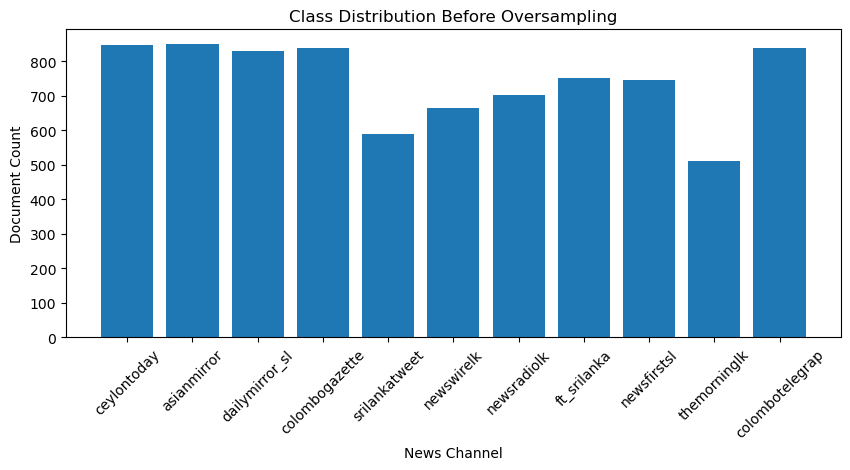

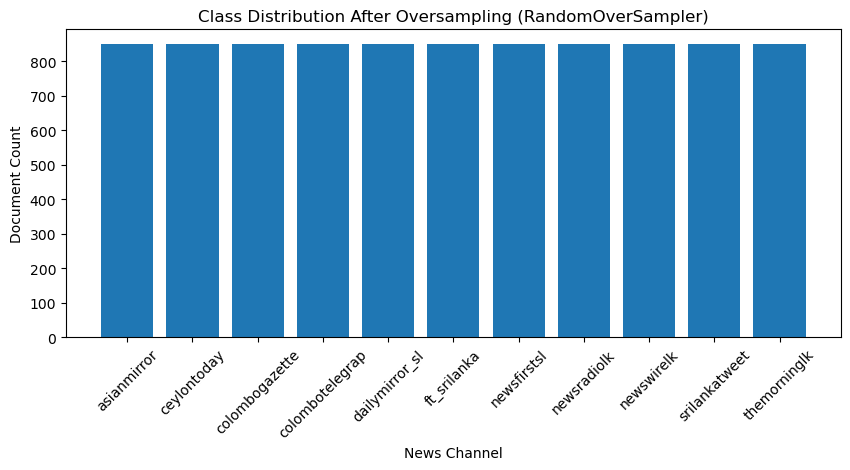

In [33]:
from imblearn.over_sampling import RandomOverSampler

random_sampler_df = all_articles_df

X_train = random_sampler_df['Document']
y_train = random_sampler_df['Class_Label']

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train.values.reshape(-1, 1), y_train)

# Resampled data is converted back into a DataFrame
df_resampled = pd.DataFrame({'Document': X_resampled.flatten(), 'Class_Label': y_resampled})

# Taking a count of the each class occurence before and after
class_counts_before = random_sampler_df['Class_Label'].value_counts()
class_counts_after = df_resampled['Class_Label'].value_counts()

# Plot class distribution diagram before oversampling
plot_class_diagram(class_counts_before, 'Class Distribution Before Oversampling')

# Plot class distribution diagram after oversampling
plot_class_diagram(class_counts_after, 'Class Distribution After Oversampling (RandomOverSampler)')


##### 2. Using SMOTE (Synthetic Minority Over-sampling Technique)

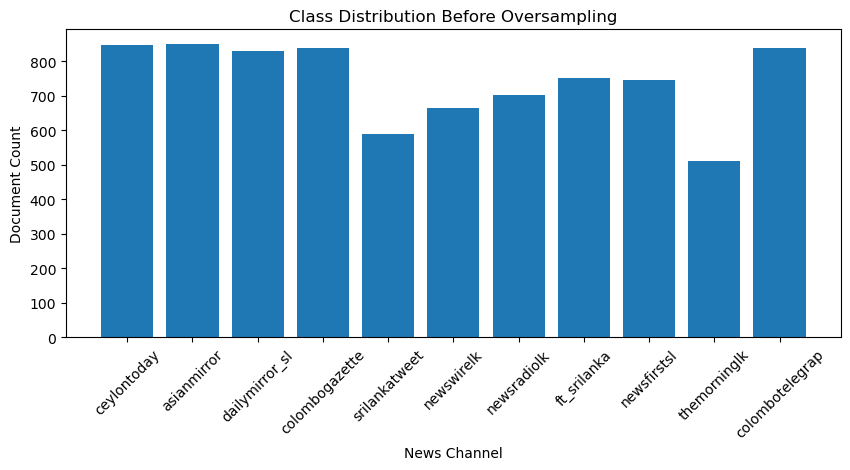

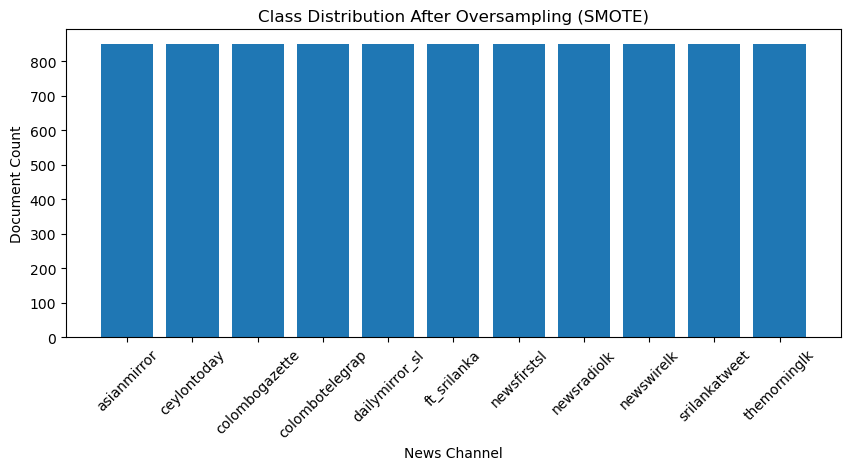

In [34]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer

smote_df = all_articles_df

X_train = smote_df['Document']
y_train = smote_df['Class_Label']

# Convert text data to numerical representation using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X_train)

smote = SMOTE(random_state=42) #Synthetic Minority Oversampling Technique
X_resampled, y_resampled = smote.fit_resample(X_tfidf, y_train)

# Resampled data is converted back into a DataFrame
df_resampled = pd.DataFrame({'Document': X_resampled, 'Class_Label': y_resampled})

# Taking a count of the each class occurence before and after
class_counts_before = smote_df['Class_Label'].value_counts()
class_counts_after = df_resampled['Class_Label'].value_counts()

# Plot class distribution diagram before oversampling
plot_class_diagram(class_counts_before, 'Class Distribution Before Oversampling')

# Plot class distribution diagram after oversampling
plot_class_diagram(class_counts_after, 'Class Distribution After Oversampling (SMOTE)')

### Splitting data into test and train

In [37]:
# Function to retieve the full corpus, respective label names and encoded numeric value

def get_data():
    full_raw_corpus = []
    labels = []
    labels_names = []
    label_counter = 0
    
    for folder in tqdm(folder_names):
        folder_path = os.path.join(unclean_folders_path, folder)
        raw_corpus = PlaintextCorpusReader(folder_path, '.*')

        for file_id in raw_corpus.fileids():
            raw_text = raw_corpus.raw(file_id).lower()
            full_raw_corpus.append(raw_text)
            labels_names.append(folder)
            labels.append(label_counter)
        label_counter += 1
    return full_raw_corpus, labels, labels_names

full_raw_corpus, labels, labels_names = get_data()

print(np.unique(labels_names))

100%|██████████| 11/11 [00:05<00:00,  2.14it/s]

['asianmirror' 'ceylontoday' 'colombogazette' 'colombotelegrap'
 'dailymirror_sl' 'ft_srilanka' 'newsfirstsl' 'newsradiolk' 'newswirelk'
 'srilankatweet' 'themorninglk']


In [39]:
# Removing the empty corpuses as they can add noise
def remove_empty_records(corpus, labels):
    filtered_corpus = []
    filtered_labels = []
    for doc, label in zip(corpus, labels):
        if doc.strip():
            filtered_corpus.append(doc)
            filtered_labels.append(label)

    return filtered_corpus, filtered_labels

full_raw_corpus, labels = remove_empty_records(full_raw_corpus, labels)

In [38]:
from sklearn.model_selection import train_test_split

# The dataset is splitted to test and train
def prepare_datasets(corpus, labels, test_size=0.3):
    train_X, test_X, train_Y, test_Y = train_test_split(corpus, labels, test_size=test_size, random_state=42)
    return train_X, test_X, train_Y, test_Y


train_corpus, test_corpus, train_labels, test_labels = prepare_datasets(full_raw_corpus, labels, test_size=0.3)

In [40]:
print('Sample document:', full_raw_corpus[10])
print('Class label:',labels[10])

Sample document:         july 18, 2023    sinhala | tamil        home local international business sports entertainment opinion videos                                              slt-mobitel rewards winners of laptop fiesta    october 29, 2022     font size   decrease font size    increase font size                   recognizing the value of both fixed and mobile customers for their loyalty, continuous bill payments, and reloads, slt-mobitel, the national ict solutions provider, rewarded the winners of the laptop fiesta program recently.  the laptop fiesta program was introduced with a focus to bridge the digital divide and uplifting digital literacy further by empowering students, entrepreneurs, small-scale businesses, and knowledge seekers.  the program enabled both fixed and mobile customers to enter the giveaway throughout the year by making bill payments and reloads and stand a chance to be the lucky winner to win laptops.                                    back to top           

In [41]:
# Train Preprocessed Tokens
train_preprocessed_tokens = data_preprocessor(train_corpus, tokenize=True, disable_tqdm=False)

norm_train_corpus = []

for corpus_list in train_preprocessed_tokens:
    for word_list in corpus_list:
        joined_text = ' '.join(word_list)
        norm_train_corpus.append(joined_text)

Preprocessing Progress: 100%|██████████| 5002/5002 [10:11<00:00,  8.18it/s]


In [42]:
# Test Preprocessed Tokens
test_preprocessed_tokens = data_preprocessor(test_corpus, tokenize=True, disable_tqdm=False)

norm_test_corpus = []

for corpus_list in test_preprocessed_tokens:
    for word_list in corpus_list:
        joined_text = ' '.join(word_list)
        norm_test_corpus.append(joined_text)

Preprocessing Progress: 100%|██████████| 2144/2144 [06:44<00:00,  5.30it/s]  


In [38]:
norm_train_corpus[10]

## --- Answer (c) ---

### Feature Extraction

#### 1. Sparse Vector Representation: 

This is a vector representation that stores only non-zero values along with their respective indices. So most of the elements in this kind of a vector are zero, which represents the unavailabilty of the unique words in the respective corpuses.

So as a sparse vector representation, Bag-of-Words (BOW) technique was chosen which used CountVectorizer to get the frequency of a word appearing in a corpus. For example the corpus will be converted to a vector where each dimension represents the frequency of that word appearing in the corpus.


**- Bag-of-Words (BOW) representation**

In [20]:
from sklearn.feature_extraction.text import CountVectorizer

def bow_extractor(corpus, ngram_range=(1,1)):

    vectorizer = CountVectorizer(min_df=1, ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features

# Bag of words (BoW) features
bow_vectorizer, bow_train_features = bow_extractor(norm_train_corpus)
bow_test_features = bow_vectorizer.transform(norm_test_corpus)

In [21]:
print(bow_train_features)

(5002, 55367)

##### Interpretation of Dimensions: 
Since Bag-of-Words is used, the dimensions of the sparse vector equals to the **unique words in the entire corpus**. So for example if we take the dimensions of the train features, the 1st dimension represents the number of articles which is 5002 articles and the 2nd dimension represents the size of the vocabulary of unique words in the entire corpus which is 55367.

#### 2. Dense Vector Representation: 

A dense vector representation is a straightforward representation where all elements in the vector including zero values are explicity kept. The drawbacks that occur due to long sparse vectore representations can be overcomed through deep learning which are dense vector representations.

To extract these strong word representations, 'Embedding' techniques are used. There are different embedding models such as Word2Vec and GLoVe which are popular and freely available. In here Word2Vec embedding technique is used.

**- Use TF-IDF (Term Frequency-Inverse Document Frequency) representation along with Word2Vec embedding technique**

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_extractor(corpus, ngram_range=(1,1)):

    vectorizer = TfidfVectorizer(min_df=1,
                                 norm='l2',
                                 smooth_idf=True,
                                 use_idf=True,
                                 ngram_range=ngram_range)
    features = vectorizer.fit_transform(corpus)
    return vectorizer, features


# TFIDF train and test features
tfidf_vectorizer, tfidf_train_features = tfidf_extractor(norm_train_corpus)
tfidf_test_features = tfidf_vectorizer.transform(norm_test_corpus)

There are 2 different weighting schemes to combine word vectors in documents such as:

1. TF-IDF Weighting
2. Word Embedding Averaging

Here TF-IDF Weighting is used as it takes both term frequency and inverse document frequency into account.

In [23]:

# TF-IDF Weighting technique used

def tfidf_weighted_averaged_word_vectors(words, tfidf_vector, tfidf_vocabulary, model, num_features):

    word_tfidfs = [tfidf_vector[0, tfidf_vocabulary.get(word)] if tfidf_vocabulary.get(word) else 0 for word in words]

    word_tfidf_map = {word:tfidf_val for word, tfidf_val in zip(words, word_tfidfs)}

    feature_vector = np.zeros((num_features,),dtype="float64")
    vocabulary = set(model.wv.index_to_key)
    wts = 0.
    for word in words:
        if word in vocabulary:
            word_vector = model.wv[word]
            weighted_word_vector = word_tfidf_map[word] * word_vector
            wts = wts + word_tfidf_map[word]
            feature_vector = np.add(feature_vector, weighted_word_vector)
    if wts:
        feature_vector = np.divide(feature_vector, wts)

    return feature_vector

def vectorizer_for_tfidf_weighted_averaged_word(corpus, tfidf_vectors, tfidf_vocabulary, model, num_features):

    docs_tfidfs = [(doc, doc_tfidf) for doc, doc_tfidf in zip(corpus, tfidf_vectors)]

    features = []
    for tokenized_sentence, tfidf in tqdm(docs_tfidfs):
        averaged_vector = tfidf_weighted_averaged_word_vectors(tokenized_sentence, tfidf, tfidf_vocabulary, model, num_features)
        features.append(averaged_vector)

    return np.array(features)

In [24]:
# tokenize the documents
tokenized_train = [nltk.word_tokenize(text) for text in norm_train_corpus]
tokenized_test = [nltk.word_tokenize(text) for text in norm_test_corpus]

In [25]:
import gensim

embedding_dim_size = 500

# Word2vec model is used
word2vec_model = gensim.models.Word2Vec(tokenized_train, vector_size=embedding_dim_size, window=100, min_count=30, sample=1e-3)

# tfidf weighted averaged word vector train and test features
vocab = tfidf_vectorizer.vocabulary_

tfidf_word_vector_train_features = vectorizer_for_tfidf_weighted_averaged_word(corpus=tokenized_train,
                                                                        tfidf_vectors=tfidf_train_features,
                                                                        tfidf_vocabulary=vocab,
                                                                        model=word2vec_model,
                                                                        num_features=500)
tfidf_word_vector_test_features = vectorizer_for_tfidf_weighted_averaged_word(corpus=tokenized_test,
                                                                        tfidf_vectors=tfidf_test_features,
                                                                        tfidf_vocabulary=vocab,
                                                                        model=word2vec_model,
                                                                        num_features=500)

C:\Users\dinis\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
100%|██████████| 2144/2144 [00:34<00:00, 62.64it/s]


In [26]:
# Array containing the tfidf word vectors

print(np.round(tfidf_word_vector_train_features, 3))

[[ 0.624  1.978  0.157 ...  0.102  0.68  -0.962]
 [-0.021  0.126 -0.598 ...  0.112 -0.527 -0.12 ]
 [-0.74   0.855  0.47  ... -0.812 -0.942 -0.293]
 ...
 [-1.176 -0.729 -0.648 ...  0.269 -0.292  1.017]
 [-0.061  0.227 -0.578 ...  0.504 -1.082 -0.199]
 [ 1.845 -0.12  -0.182 ...  0.575 -0.428  0.955]]


In [27]:
print('Mean Value = ' , np.mean(tfidf_word_vector_train_features))
print('Standard Deviation = ' , np.std(tfidf_word_vector_train_features))

Mean Value =  -0.017951297037165456
Standard Deviation =  0.654421403991217


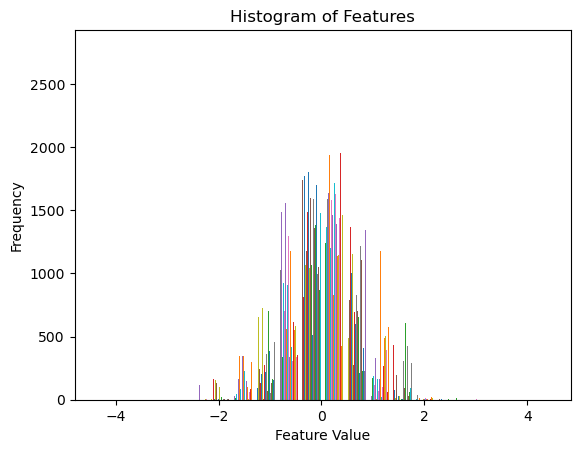

In [36]:
# Histogram of all the features in the dataset
plt.hist(tfidf_word_vector_train_features, bins=20)
plt.xlabel('Feature Value')
plt.ylabel('Frequency')
plt.title('Histogram of Features')
plt.show()

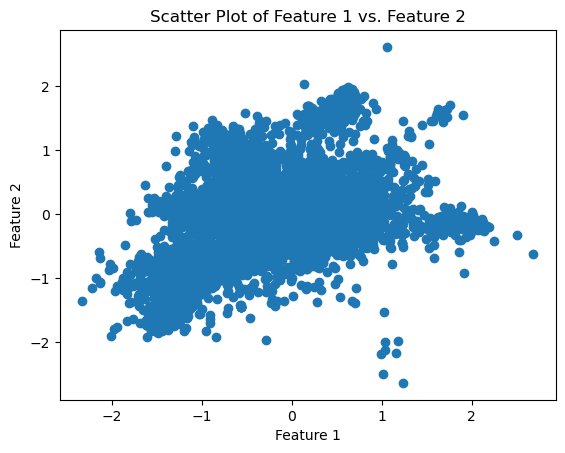

In [34]:
# Scatter plot taking two numerical features into consideration (First one and second)
plt.scatter(tfidf_word_vector_train_features[:, 0], tfidf_word_vector_train_features[:, 1])
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Scatter Plot of Feature 1 vs. Feature 2')
plt.show()

##### Justification of Dimensions: 
Since tfidf with Word2vec embedding is used, the dimensions of the dense vector depends on the features extracted from the inserted data. Here the dimensionality is greater than of the sparse vector as unlike sparse, these vectors store all the elements.

The dimensionality of this kind of vector depends upon the size of the embeddings used to extract features for the word embedding model. In here, for Word2Vec, an **embedding size of 500** is used which means the embeddings generated by the model will be 500-dimensional.


## --- Answer (d) ---

In [37]:
# Function to calculate metrics such as accuracy, precision, recall and F1-score

def calculate_metrics(true_labels, predicted_labels):

    accuracy = metrics.accuracy_score(true_labels, predicted_labels)
    precision = metrics.precision_score(true_labels, predicted_labels, average='weighted')
    recall = metrics.recall_score(true_labels, predicted_labels, average='weighted')
    f1_score = metrics.f1_score(true_labels, predicted_labels,average='weighted')

    print('Accuracy  :', np.round(accuracy, 4))
    print('Precision :', np.round(precision, 4))
    print('Recall    :', np.round(recall, 4))
    print('F1 Score  :', np.round(f1_score, 4))

    return accuracy, precision, recall, f1_score


### Use of Non-Deep Algorithms

##### With Bag of Words (BOW) features

In [38]:
from sklearn.naive_bayes import MultinomialNB
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

evaluation_data_bow = []
evaluation_data_tfidf = []

##### Non-Deep Learning algorithms used and reasons:
1. Multinomial Naive Bayes Classifier :-
- This is a simple but a highly effective algorithm when it comes to text classification tasks and has shown good results when dealing with a large number of features. The algorithm is based on Bayes' Theorem which is used to identify the probabilty of a hypothesis. This algorithm has low computational overhead as well, making it possible to use for large text classification tasks and it is also a reason why this can be seen widely used for sentiment analysis, spam detection etc.

2. XGBoost Classifier :-
- Gradient boosting algorithms such as XGBoost has a reputation same as Naive Bayes for it's effectivity in text classification and possibility to handle substantial feature spaces. They are popular for it's nature of powerful ensembles which combines weak learners to build strong learner. It uses Regularization rechniques which prevents overfitting while improving generalization and has shown top performance in different text classification tasks.

3. Random Forest Classifier:-
- Random Forest is kind of an advanced version of Decision Trees, which can be defined as combination of multiple deciosion trees resulting in an ensemble to make predictions. They are known to be powerful that Decision Trees and often with proper feature engineering, has shown exceptional results for text classification assignments. These algorithms can work with high-dimenstional data easily related to other algorithms and is known to be strong against overfitting.




Apart from the above mentioned algorithms, Support Vector Machine, Logistic Regression, K-Nearest Neighbours, Decision Trees and Multiomial Logistic Regression can also deal with text classification tasks but they do have their own pros and cons. They were not considered for the courswork because of the reasons such as simplisity, requirement of proper distance metrics (eg: KNN) and not properly working for high-dimensional data (eg: KNN).

**Multinomial Naive Bayes classifier with BOW**

In [39]:
nb_classifier_bow = MultinomialNB()

# Use bag of words features to train
nb_classifier_bow.fit(bow_train_features, train_labels)

# Use test set to make predictions
nb_predictions_bow = nb_classifier_bow.predict(bow_test_features)

# Model Evaluation
accuracy, precision, recall, f1_score = calculate_metrics(test_labels, nb_predictions_bow)
evaluation_data_bow.append(["Multinomial Naive Bayes", accuracy, precision, recall, f1_score])

Accuracy  : 0.9911
Precision : 0.9912
Recall    : 0.9911
F1 Score  : 0.9911


**XGBoost classifier with BOW**

In [40]:
xgb_classifier_bow = xgb.XGBClassifier()

# Use bag of words features to train
xgb_classifier_bow.fit(bow_train_features, train_labels)

# Use test set to make predictions
xgb_predictions_bow = xgb_classifier_bow.predict(bow_test_features)

# Model Evaluation
accuracy, precision, recall, f1_score = calculate_metrics(test_labels, xgb_predictions_bow)
evaluation_data_bow.append(["XGBoost", accuracy, precision, recall, f1_score])

Accuracy  : 0.9967
Precision : 0.9968
Recall    : 0.9967
F1 Score  : 0.9967


**Random Forest classifier with BOW**

In [41]:
rf_classifier_bow = RandomForestClassifier()

# Use bag of words features to train
rf_classifier_bow.fit(bow_train_features, train_labels)

# Use test set to make predictions
rf_predictions_bow = rf_classifier_bow.predict(bow_test_features)

# Model Evaluation
accuracy, precision, recall, f1_score = calculate_metrics(test_labels, rf_predictions_bow)
evaluation_data_bow.append(["Random Forest", accuracy, precision, recall, f1_score])

Accuracy  : 0.9963
Precision : 0.9963
Recall    : 0.9963
F1 Score  : 0.9963


In [42]:
# Print the comparison table
headers = ["Classifier for BOW", "Accuracy", "Precision", "Recall", "F1-score"]
print(tabulate(evaluation_data_bow, headers=headers, tablefmt="grid"))

+-------------------------+------------+-------------+----------+------------+
| Classifier for BOW      |   Accuracy |   Precision |   Recall |   F1-score |
+=========================+============+=============+==========+============+
| Multinomial Naive Bayes |   0.991138 |    0.991208 | 0.991138 |   0.991146 |
+-------------------------+------------+-------------+----------+------------+
| XGBoost                 |   0.996735 |    0.996768 | 0.996735 |   0.996732 |
+-------------------------+------------+-------------+----------+------------+
| Random Forest           |   0.996269 |    0.996306 | 0.996269 |   0.996262 |
+-------------------------+------------+-------------+----------+------------+


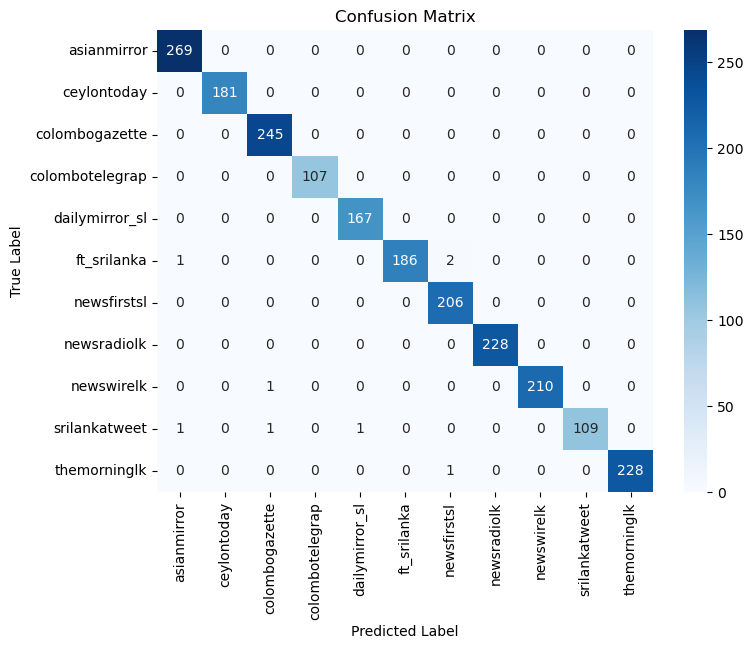

In [66]:
cm_bow = metrics.confusion_matrix(test_labels, rf_predictions_bow)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_bow, annot=True, fmt='d', cmap='Blues', xticklabels=folder_names, yticklabels=folder_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

##### With tfidf features using embedding technique Word2Vec

**Multinomial Naive Bayes classifier with tfidf**

In [52]:
nb_classifier_tfidf = MultinomialNB()

from sklearn.preprocessing import MinMaxScaler #fixed import

scaler = MinMaxScaler()
tfidf_word_vector_train_features = scaler.fit_transform(tfidf_word_vector_train_features)
tfidf_word_vector_test_features = scaler.transform(tfidf_word_vector_test_features)

# Use tfidf word vector features to train
nb_classifier_tfidf.fit(tfidf_word_vector_train_features, train_labels)

# Use test set to make predictions
nb_predictions_tfidf = nb_classifier_tfidf.predict(tfidf_word_vector_test_features)

# Model Evaluation
accuracy, precision, recall, f1_score = calculate_metrics(test_labels, nb_predictions_tfidf)
evaluation_data_tfidf.append(["Multinomial Naive Bayes", accuracy, precision, recall, f1_score])

Accuracy  : 0.9184
Precision : 0.9375
Recall    : 0.9184
F1 Score  : 0.9221


**XGBoost classifier with tfidf**

In [53]:
xgb_classifier_tfidf = xgb.XGBClassifier()

# Use tfidf word vector features to train
xgb_classifier_tfidf.fit(tfidf_word_vector_train_features, train_labels)

# Use test set to make predictions
xgb_predictions_tfidf = xgb_classifier_tfidf.predict(tfidf_word_vector_test_features)

# Model Evaluation
accuracy, precision, recall, f1_score = calculate_metrics(test_labels, xgb_predictions_tfidf)
evaluation_data_tfidf.append(["XGBoost", accuracy, precision, recall, f1_score])

Accuracy  : 0.9711
Precision : 0.9716
Recall    : 0.9711
F1 Score  : 0.9712


**Random Forest classifier with tfidf**

In [54]:
rf_classifier_tfidf = RandomForestClassifier()

# Use tfidf word vector features to train
rf_classifier_tfidf.fit(tfidf_word_vector_train_features, train_labels)

# Use test set to make predictions
rf_predictions_tfidf = rf_classifier_tfidf.predict(tfidf_word_vector_test_features)

# Model Evaluation
accuracy, precision, recall, f1_score = calculate_metrics(test_labels, rf_predictions_tfidf)
evaluation_data_tfidf.append(["Random Forest", accuracy, precision, recall, f1_score])

Accuracy  : 0.9669
Precision : 0.9686
Recall    : 0.9669
F1 Score  : 0.9673


In [55]:
# Print the comparison table
headers = ["Classifier for tfidf", "Accuracy", "Precision", "Recall", "F1-score"]
print(tabulate(evaluation_data_tfidf, headers=headers, tablefmt="grid"))

+-------------------------+------------+-------------+----------+------------+
| Classifier for tfidf    |   Accuracy |   Precision |   Recall |   F1-score |
+=========================+============+=============+==========+============+
| Multinomial Naive Bayes |   0.918377 |    0.937484 | 0.918377 |   0.922083 |
+-------------------------+------------+-------------+----------+------------+
| XGBoost                 |   0.971082 |    0.97161  | 0.971082 |   0.971232 |
+-------------------------+------------+-------------+----------+------------+
| Random Forest           |   0.966884 |    0.968571 | 0.966884 |   0.967332 |
+-------------------------+------------+-------------+----------+------------+


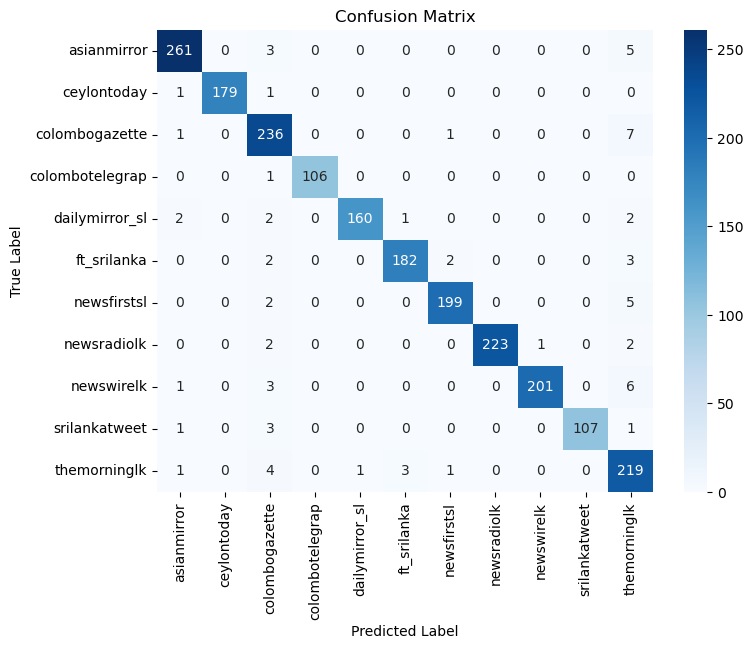

In [65]:
cm_tfidf = metrics.confusion_matrix(test_labels, rf_predictions_tfidf)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_tfidf, annot=True, fmt='d', cmap='Blues', xticklabels=folder_names, yticklabels=folder_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**Final Remarks:** For both Bag-of-Words features and TFIDF features, **XGBoost classifier** provided the best results from all three algorithms

## --- Answer (e) ---

### *Deep Learning Classifiers*

### 1. CNN Classifier with GloVe Embeddings:


**Architecture:** Since local variations and patterns in the text data can be successfully captured for text analysis, CNN (Convolutional Neural Network) was chosen to be used as the first approach. Connvolutional neural networks are different from just neural networks as in a CNN it goes through a variety of layers operating over a number of outputs. These classifiers usually includes a embedding layer along with convolutional layers, dropout layers, max-pooling layers and dense layers with a specific activation function.

**Embedding Technique:** GloVe (Global Vectors for Word Representation)

**Justification:** GLoVe is a popular widely used unsupervised word embedding technique for gathering word vector representations. When it comes to Word2Vec, it mainly incorparates with just local statistics but for GLoVe, it does not just use local statistics but also global statistics to create word vectors. In this context global statistics refers to word co-occurence probabilities from a corpus.

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Embedding, Dropout
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Text Data Tokenizing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(norm_train_corpus)
train_sequences = tokenizer.texts_to_sequences(norm_train_corpus)
test_sequences = tokenizer.texts_to_sequences(norm_test_corpus)

embedding_dim = 100
embedding_index = {}

# Padded the sequences in order to get the same length
max_sequence_length = 100
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post')
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post')

# Code to Load GloVe
glove_file = '/content/drive/My Drive/Masters/glove.6B.100d.txt'

with open(glove_file, 'r', encoding='utf-8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Embedding matrix creation
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Class labels should be converted to one_hot_encoding
num_classes = len(np.unique(labels))
train_labels_onehot = to_categorical(train_labels, num_classes=num_classes)
test_labels_onehot = to_categorical(test_labels, num_classes=num_classes)

# Structuring the CNN Model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model.add(Dropout(0.2)) # Adding a dropout layer to prevent overfitting
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01))) # Added L2 regularization to Dense layers to prevent model from overfitting
model.add(Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.01)))

# used an optimizer with a lower learning rate as high can lead to overfitting
optimizer = Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Model training
model.fit(train_padded_sequences, train_labels_onehot, epochs=200, batch_size=32, validation_split=0.2)

# Evaluation
loss, accuracy = model.evaluate(test_padded_sequences, test_labels_onehot)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

Epoch 1/200
126/126 [==============================] - 2s 8ms/step - loss: 0.3431 - accuracy: 0.9362 - val_loss: 0.0423 - val_accuracy: 0.9930
Epoch 2/200
126/126 [==============================] - 1s 5ms/step - loss: 0.0167 - accuracy: 0.9973 - val_loss: 0.0408 - val_accuracy: 0.9950
Epoch 3/200
126/126 [==============================] - 1s 5ms/step - loss: 0.0121 - accuracy: 0.9975 - val_loss: 0.0360 - val_accuracy: 0.9950
Epoch 4/200
126/126 [==============================] - 1s 5ms/step - loss: 0.0097 - accuracy: 0.9978 - val_loss: 0.0385 - val_accuracy: 0.9940
Epoch 5/200
126/126 [==============================] - 1s 7ms/step - loss: 0.0081 - accuracy: 0.9988 - val_loss: 0.0329 - val_accuracy: 0.9960
Epoch 6/200
126/126 [==============================] - 1s 7ms/step - loss: 0.0093 - accuracy: 0.9980 - val_loss: 0.0287 - val_accuracy: 0.9960
Epoch 7/200
126/126 [==============================] - 1s 6ms/step - loss: 0.0090 - accuracy: 0.9983 - val_loss: 0.0336 - val_accuracy: 0.9960

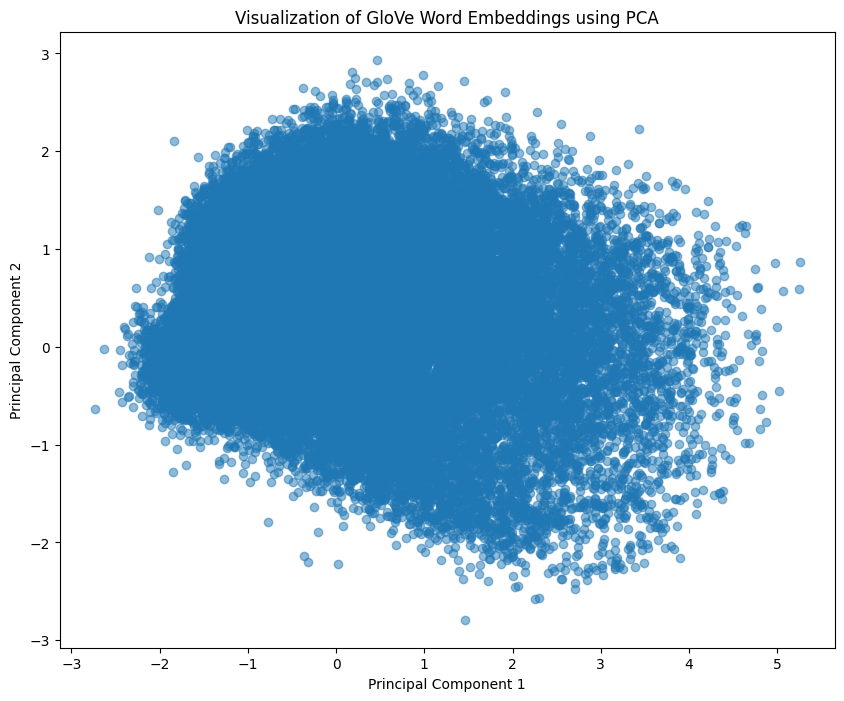

In [37]:
from sklearn.decomposition import PCA

# Perform Principal Component Analysis (PCA) to dimenstionality reduction to 2D
pca = PCA(n_components=2)
embedding_pca = pca.fit_transform(embedding_matrix)

# Plot the results of the reduced embeddings
plt.figure(figsize=(10, 8))
plt.scatter(embedding_pca[:, 0], embedding_pca[:, 1], alpha=0.5)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Visualization of GloVe Word Embeddings using PCA')
plt.show()

### 2.  LSTM Classifier with Word Embeddings:


**Architecture:** LSTM (Long Short-Term Memory) is a recurrent neural network which is considered superior related to traditional neural networks due to it's ability of memorizing certain patterns. Since capturing dependencies that are long-range in text data is essential for text classification, this architecture was selected. The LSTM classifier is composed of an embedding layer, an LSTM layer and a dense output layer with an activation function.

**Embedding Technique**: Word2Vec

**Justification:** Word2Vec is also another popular widely used word embedding technique which creates vectors of the words or simply feature vectors that represent the words in a particular corpus. Passing through Word2Vec will result each word represented as a dense vector and the resulting vectors can be pre-trained using a selected corpus, finally allowing the model to detect similarities mathematically.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Text Data Tokenizing and generating word embeddings
tokenizer = Tokenizer()
tokenizer.fit_on_texts(full_raw_corpus)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
max_sequence_length = max(len(sequence) for sequence in tokenized_train)
embedding_dim = 100

# Create Word2Vec embedding matrix
embedding_dim = 100  # Dimensionality of Word2Vec embeddings
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if word in word2vec_model.wv.vocab:
        embedding_matrix[i] = word2vec_model.wv[word]

# Converting text data to sequences
train_sequences = tokenizer.texts_to_sequences(norm_train_corpus)
test_sequences = tokenizer.texts_to_sequences(norm_test_corpus)

# Padded the sequences in order to get the same length
train_data = pad_sequences(train_sequences, maxlen=max_sequence_length)
test_data = pad_sequences(test_sequences, maxlen=max_sequence_length)

# Class labels should be converted to one_hot_encoding
num_classes = len(np.unique(labels))
train_labels_onehot = to_categorical(train_labels, num_classes=num_classes)
test_labels_onehot = to_categorical(test_labels, num_classes=num_classes)

# Structuring the LSTM Model
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix], 
                    input_length=max_sequence_length, trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2)) # Adding a dropout layer to prevent overfitting
model.add(Dense(64, activation='relu',  kernel_regularizer=l2(0.01))) # Added L2 regularization to Dense layers to prevent model from overfitting
model.add(BatchNormalization()) # Added Batch normalization to improve the model's stability and prevent overfitting.
model.add(Dense(num_classes, activation='softmax'))

# used an optimizer with a lower learning rate as high can lead to overfitting
optimizer = Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
model.fit(train_data, train_labels_onehot, epochs=10, batch_size=32, validation_split=0.2)

# Evaluation
loss, accuracy = model.evaluate(test_data, test_labels_onehot)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

Epoch 1/10
51/51 [==============================] - 781s 15s/step - loss: 0.4994 - accuracy: 0.9378 - val_loss: 0.0067 - val_accuracy: 1.0000
Epoch 2/10
51/51 [==============================] - 757s 15s/step - loss: 0.0197 - accuracy: 0.9975 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 3/10
51/51 [==============================] - 753s 15s/step - loss: 0.0116 - accuracy: 0.9982 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 4/10
51/51 [==============================] - 761s 15s/step - loss: 0.0073 - accuracy: 0.9994 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 5/10
51/51 [==============================] - 754s 15s/step - loss: 0.0063 - accuracy: 0.9994 - val_loss: 6.8589e-04 - val_accuracy: 1.0000
Epoch 6/10
51/51 [==============================] - 755s 15s/step - loss: 0.0064 - accuracy: 0.9994 - val_loss: 6.2757e-04 - val_accuracy: 1.0000
Epoch 7/10
51/51 [==============================] - 751s 15s/step - loss: 0.0054 - accuracy: 0.9994 - val_loss: 5.5071e-04 - val_accuracy: 1

### 3.Transformer Classifier with BERT:


**Architecture:** Along side Convolutional and Recurrent neural networks, transfomer-based models has been proven for providing remarkable performance for text analytics in the NLP field. Google's BERT which was released in 2018 has been considered one of the outstanding milestones in NLP history. Unlike previous models, BERT consists of multi-layer encoders that allow bidirectional manner processing, making the captured context, contextually rich.

**Contextual Embedding Technique:** BERT (Bidirectional Encoder Representations from Transformers)

**Justification:** BERT is a contextual embedding technique and unlike traditional embedding techniques like the above mentioned Word2Vec and GLoVe, these are powerful for understanding the word meaning by providing dynamic representations. Also this has proven to be successful in giving robust results in numerous NLP tasks leading to significant improvements mainly due to it's structure of bidirectional training.

#### NOTE: Due to lack of computation resources, the code was not trained untill the end giving unfinished results. 

In [ ]:
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model


# Loading the BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Text Data Tokenizing
train_sentences = [" ".join(tokenizer.tokenize(text)) for text in norm_train_corpus]
test_sentences = [" ".join(tokenizer.tokenize(text)) for text in norm_test_corpus]

# Text data should be converted into input features
train_input = tokenizer(train_sentences, padding=True, truncation=True, return_tensors='tf')
test_input = tokenizer(test_sentences, padding=True, truncation=True, return_tensors='tf')

# Class labels should be converted to one_hot_encoding
num_classes = len(np.unique(labels))
train_labels_onehot = to_categorical(train_labels, num_classes=num_classes)
test_labels_onehot = to_categorical(test_labels, num_classes=num_classes)

bert_model = TFBertModel.from_pretrained('bert-base-uncased')

# Structuring the BERT-based model
input_ids = Input(shape=(train_input['input_ids'].shape[1],), dtype='int32')
attention_mask = Input(shape=(train_input['attention_mask'].shape[1],), dtype='int32')
embeddings = bert_model(input_ids, attention_mask=attention_mask)[0]
x = GlobalMaxPooling1D()(embeddings)
x = Dense(64, activation='relu')(x)
output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=[input_ids, attention_mask], outputs=output_layer)

# used an optimizer with a lower learning rate as high can lead to overfitting
optimizer = Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Model training
train_data = (train_input['input_ids'].numpy(), train_input['attention_mask'].numpy())  

history = model.fit(train_data, train_labels_onehot, epochs=10, batch_size=8, validation_split=0.2)

# Evaluation
test_data = (test_input['input_ids'].numpy(), test_input['attention_mask'].numpy())

test_loss, test_accuracy = model.evaluate(test_data, test_labels_onehot)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Epoch 1/10


203/203 [==============================] - 271s 1s/step - loss: 1.4739 - accuracy: 0.2606 - val_loss: 2.8368 - val_accuracy: 0.2537
Epoch 2/10
203/203 [==============================] - 214s 1s/step - loss: 1.3826 - accuracy: 0.2730 - val_loss: 2.6741 - val_accuracy: 0.2537
Epoch 3/10
203/203 [==============================] - 203s 1s/step - loss: 1.3832 - accuracy: 0.2822 - val_loss: 2.6590 - val_accuracy: 0.2537
Epoch 4/10
203/203 [==============================] - 199s 982ms/step - loss: 1.3809 - accuracy: 0.2871 - val_loss: 2.6506 - val_accuracy: 0.2537
Epoch 5/10
203/203 [==============================] - 199s 982ms/step - loss: 1.3798 - accuracy: 0.2871 - val_loss: 2.6441 - val_accuracy: 0.2537
Epoch 6/10
203/203 [==============================] - 203s 1s/step - loss: 1.3790 - accuracy: 0.2871 - val_loss: 2.6385 - val_accuracy: 0.2537
Epoch 7/10
203/203 [==============================] - 203s 1s/step - loss: 1.3786 - accuracy: 0.2871 - val_loss: 2.6352 - val_accuracy: 0.2537
Epoc

**Final Remarks:** It can be observed that **CNN Classifier with GloVe Embeddings** has given the best results as LSTM classifier tends to be overfitting and incorrect results while Transformer Classifier with BERT has shown low accuracies as the model was not trained properly for that.